# This notebook will be used to test the correctness of my implementation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd

from torchvision import transforms
import torch
from imutils import paths
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn import BCEWithLogitsLoss, Sigmoid, BCELoss
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import LinearLR, ExponentialLR


# import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import  DiceLoss


import os 
import time 
from tqdm import tqdm


/home/dah/miniconda3/envs/computer_vision/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Testing Encoder block

In [2]:
import sys

sys.path.append("../src")
from encoder import Encoder

In [3]:
import torch

encoder = Encoder(channels=(3, 64, 128, 256, 512, 1024))

In [4]:
print(encoder)

Encoder(
  (encoder_blocks): ModuleList(
    (0): Block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
    )
    (1): Block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
    )
    (2): Block(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1):

In [5]:

x = torch.randn(1, 3, 572, 572)  # Batch size of 1, 3 input channels, 572x572 image
features = encoder(x)
for f in features:
    print(f.shape)
    

torch.Size([1, 64, 568, 568])
torch.Size([1, 128, 280, 280])
torch.Size([1, 256, 136, 136])
torch.Size([1, 512, 64, 64])
torch.Size([1, 1024, 28, 28])


## Testing Encoder block

In [6]:
from decoder import Decoder

In [7]:
decoder = Decoder(channels=(1024, 512, 256, 128, 64))

In [8]:
print(decoder)

Decoder(
  (upconvs): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (3): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  )
  (decoder_blocks): ModuleList(
    (0): Block(
      (conv1): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1))
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
    )
    (1): Block(
      (conv1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1,

In [9]:
x = features[-1]
x.shape

torch.Size([1, 1024, 28, 28])

In [10]:
# feature_maps = [features[-i] for i in range(2,len(features)+1)]
feature_maps = features[::-1]

In [11]:
for fm in feature_maps:
    print(fm.shape)

torch.Size([1, 1024, 28, 28])
torch.Size([1, 512, 64, 64])
torch.Size([1, 256, 136, 136])
torch.Size([1, 128, 280, 280])
torch.Size([1, 64, 568, 568])


In [12]:
output = decoder(feature_maps[0], feature_maps[1:])
print(output.shape) 

torch.Size([1, 64, 388, 388])


## Testing UNet

In [13]:
from unet import UNet

In [14]:
model = UNet(ouput_dim=(256, 256), encoder_channels=(3, 64, 128, 256, 512, 1024), decoder_channels=(1024, 512, 256, 128, 64))
print(model)

UNet(
  (encoder): Encoder(
    (encoder_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU()
      )
      (1): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU()
      )
      (2): Block(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (bn1): BatchNorm2d(256, eps=1e-05, momentum

In [15]:

x = torch.randn(1, 3, 572, 572)  # Example input tensor
output = model(x)
print(output.shape)  # Expected output shape


torch.Size([1, 1, 256, 256])


## Training unet

In [16]:

IMAGE_DATASET_PATH = "/home/dah/computer_vision/datasets/segmentation_full_body_tik_tok_2615_img/images"
MASK_DATASET_PATH = "/home/dah/computer_vision/datasets/segmentation_full_body_tik_tok_2615_img/masks"

INPUT_IMAGE_HEIGHT = 256
INPUT_IMAGE_WIDTH = 256



image_paths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
mask_paths = sorted(list(paths.list_images(MASK_DATASET_PATH)))



In [17]:
image_paths[0:3]

['/home/dah/computer_vision/datasets/segmentation_full_body_tik_tok_2615_img/images/0_00030.png',
 '/home/dah/computer_vision/datasets/segmentation_full_body_tik_tok_2615_img/images/0_00180.png',
 '/home/dah/computer_vision/datasets/segmentation_full_body_tik_tok_2615_img/images/0_00330.png']

In [18]:
mask_paths[0:3]

['/home/dah/computer_vision/datasets/segmentation_full_body_tik_tok_2615_img/masks/0_00030.png',
 '/home/dah/computer_vision/datasets/segmentation_full_body_tik_tok_2615_img/masks/0_00180.png',
 '/home/dah/computer_vision/datasets/segmentation_full_body_tik_tok_2615_img/masks/0_00330.png']

In [19]:
(train_images, test_images,train_masks, test_masks) = train_test_split(image_paths, mask_paths,test_size=0.2, random_state=42)

In [20]:
# train_images

In [21]:
from segmentation_dataset import SegmentationDataset

In [22]:
# define transformations
# image_transforms = transforms.Compose([transforms.ToPILImage(),transforms.Resize((INPUT_IMAGE_HEIGHT,INPUT_IMAGE_WIDTH)),transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
image_transforms = transforms.Compose([transforms.ToPILImage(),transforms.Resize((INPUT_IMAGE_HEIGHT,INPUT_IMAGE_WIDTH)),transforms.ToTensor()])
mask_transforms = transforms.Compose([transforms.ToPILImage(),transforms.Resize((INPUT_IMAGE_HEIGHT,INPUT_IMAGE_WIDTH)),transforms.ToTensor()])
# create the train and test datasets
train_data = SegmentationDataset(image_paths=train_images, mask_paths=train_masks,image_transforms=image_transforms, mask_transforms=mask_transforms)
test_data = SegmentationDataset(image_paths=test_images, mask_paths=test_masks,image_transforms=image_transforms, mask_transforms=mask_transforms)

TRAIN_BATCH_SIZE = 20
TEST_BATCH_SIZE = 10

print(f"[INFO] found {len(train_data)} examples in the training set...")
print(f"[INFO] found {len(test_data)} examples in the test set...")
# create the training and test data loaders
train_loader = DataLoader(train_data, shuffle=True,batch_size=TRAIN_BATCH_SIZE, num_workers=10)
test_loader = DataLoader(test_data, shuffle=False,batch_size=TEST_BATCH_SIZE,num_workers=4)

[INFO] found 2092 examples in the training set...
[INFO] found 523 examples in the test set...


In [23]:
from trainer import UNetTrainer
from utils import set_seed

In [24]:
set_seed()

LR = 1e-2

NUM_EPOCHS = 10

# CPU_USAGE = os.cpu_count() - 4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = "cpu"

# initialize our UNet model
# model = UNet(ouput_dim=(INPUT_IMAGE_HEIGHT,INPUT_IMAGE_WIDTH), encoder_channels = (3, 64, 128, 256, 512),decoder_channels = (512,256, 128, 64)).to(DEVICE)
# model = UNet(ouput_dim=(INPUT_IMAGE_HEIGHT,INPUT_IMAGE_WIDTH), encoder_channels = (3,32, 64, 128),decoder_channels = (128, 64, 32), num_class=1).to(DEVICE)
model = UNet(ouput_dim=(INPUT_IMAGE_HEIGHT,INPUT_IMAGE_WIDTH), encoder_channels = (3,16, 32, 64),decoder_channels = (64, 32, 16), num_class=1).to(DEVICE)

# initialize loss function and optimizer
loss_func = BCEWithLogitsLoss()
# loss_func = DiceLoss(mode='binary')
# loss_func = BCELoss()
# loss_func = Sigmoid()
# optimizer = SGD(model.parameters(), lr=LR)
optimizer = SGD(model.parameters(), lr=LR, momentum=0.9)
# optimizer = Adam(model.parameters(), lr=LR)

# calculate steps per epoch for training and test set
train_steps = len(train_data) // TRAIN_BATCH_SIZE
test_steps = len(test_data) // TEST_BATCH_SIZE

# scheduler = LinearLR(optimizer, start_factor=LR, end_factor=1e-5, total_iters=NUM_EPOCHS*2) 
scheduler = ExponentialLR(optimizer, gamma=0.9)

> SEEDING DONE


In [25]:

trainer = UNetTrainer(model=model, train_loader=train_loader, test_loader=test_loader, loss_func=loss_func, optimizer = optimizer, scheduler = scheduler, device=DEVICE)

In [26]:
DEVICE

'cuda'

In [43]:
history = trainer.train(num_epochs=NUM_EPOCHS +50)

Epoch 1/60: 100%|██████████| 105/105 [00:10<00:00,  9.74it/s]


Epoch 0: SGD lr=0.0012
Train loss: 0.162934, Test loss: 0.1652


Epoch 2/60: 100%|██████████| 105/105 [00:10<00:00,  9.94it/s]


Epoch 1: SGD lr=0.0011
Train loss: 0.163278, Test loss: 0.1655


Epoch 3/60: 100%|██████████| 105/105 [00:10<00:00,  9.55it/s]


Epoch 2: SGD lr=0.0010
Train loss: 0.161721, Test loss: 0.1672


Epoch 4/60: 100%|██████████| 105/105 [00:11<00:00,  9.12it/s]


Epoch 3: SGD lr=0.0009
Train loss: 0.160943, Test loss: 0.1619


Epoch 5/60: 100%|██████████| 105/105 [00:11<00:00,  9.17it/s]


Epoch 4: SGD lr=0.0008
Train loss: 0.160195, Test loss: 0.1588


Epoch 6/60: 100%|██████████| 105/105 [00:11<00:00,  8.93it/s]


Epoch 5: SGD lr=0.0007
Train loss: 0.160507, Test loss: 0.1595


Epoch 7/60: 100%|██████████| 105/105 [00:11<00:00,  8.86it/s]


Epoch 6: SGD lr=0.0006
Train loss: 0.159196, Test loss: 0.1642


Epoch 8/60: 100%|██████████| 105/105 [00:11<00:00,  8.93it/s]


Epoch 7: SGD lr=0.0006
Train loss: 0.159377, Test loss: 0.1573


Epoch 9/60: 100%|██████████| 105/105 [00:11<00:00,  8.85it/s]


Epoch 8: SGD lr=0.0005
Train loss: 0.159226, Test loss: 0.1582


Epoch 10/60: 100%|██████████| 105/105 [00:11<00:00,  8.90it/s]


Epoch 9: SGD lr=0.0005
Train loss: 0.159018, Test loss: 0.1590


Epoch 11/60: 100%|██████████| 105/105 [00:11<00:00,  8.78it/s]


Epoch 10: SGD lr=0.0004
Train loss: 0.157459, Test loss: 0.1555


Epoch 12/60: 100%|██████████| 105/105 [00:12<00:00,  8.74it/s]


Epoch 11: SGD lr=0.0004
Train loss: 0.158456, Test loss: 0.1600


Epoch 13/60: 100%|██████████| 105/105 [00:11<00:00,  8.91it/s]


Epoch 12: SGD lr=0.0003
Train loss: 0.157354, Test loss: 0.1570


Epoch 14/60: 100%|██████████| 105/105 [00:12<00:00,  8.71it/s]


Epoch 13: SGD lr=0.0003
Train loss: 0.157913, Test loss: 0.1538


Epoch 15/60: 100%|██████████| 105/105 [00:12<00:00,  8.74it/s]


Epoch 14: SGD lr=0.0003
Train loss: 0.157464, Test loss: 0.1540


Epoch 16/60: 100%|██████████| 105/105 [00:12<00:00,  8.72it/s]


Epoch 15: SGD lr=0.0003
Train loss: 0.157106, Test loss: 0.1549


Epoch 17/60: 100%|██████████| 105/105 [00:12<00:00,  8.71it/s]


Epoch 16: SGD lr=0.0002
Train loss: 0.156313, Test loss: 0.1559


Epoch 18/60: 100%|██████████| 105/105 [00:11<00:00,  8.75it/s]


Epoch 17: SGD lr=0.0002
Train loss: 0.157300, Test loss: 0.1549


Epoch 19/60: 100%|██████████| 105/105 [00:11<00:00,  8.84it/s]


Epoch 18: SGD lr=0.0002
Train loss: 0.156792, Test loss: 0.1538


Epoch 20/60: 100%|██████████| 105/105 [00:11<00:00,  8.80it/s]


Epoch 19: SGD lr=0.0002
Train loss: 0.156267, Test loss: 0.1544


Epoch 21/60: 100%|██████████| 105/105 [00:11<00:00,  8.75it/s]


Epoch 20: SGD lr=0.0001
Train loss: 0.155994, Test loss: 0.1545


Epoch 22/60: 100%|██████████| 105/105 [00:11<00:00,  8.77it/s]


Epoch 21: SGD lr=0.0001
Train loss: 0.156068, Test loss: 0.1549


Epoch 23/60: 100%|██████████| 105/105 [00:11<00:00,  8.83it/s]


Epoch 22: SGD lr=0.0001
Train loss: 0.155771, Test loss: 0.1539


Epoch 24/60: 100%|██████████| 105/105 [00:12<00:00,  8.56it/s]


Epoch 23: SGD lr=0.0001
Train loss: 0.155599, Test loss: 0.1535


Epoch 25/60: 100%|██████████| 105/105 [00:12<00:00,  8.73it/s]


Epoch 24: SGD lr=0.0001
Train loss: 0.155370, Test loss: 0.1536


Epoch 26/60: 100%|██████████| 105/105 [00:12<00:00,  8.61it/s]


Epoch 25: SGD lr=0.0001
Train loss: 0.155954, Test loss: 0.1533


Epoch 27/60: 100%|██████████| 105/105 [00:11<00:00,  8.75it/s]


Epoch 26: SGD lr=0.0001
Train loss: 0.155657, Test loss: 0.1529


Epoch 28/60: 100%|██████████| 105/105 [00:12<00:00,  8.66it/s]


Epoch 27: SGD lr=0.0001
Train loss: 0.155609, Test loss: 0.1543


Epoch 29/60: 100%|██████████| 105/105 [00:12<00:00,  8.60it/s]


Epoch 28: SGD lr=0.0001
Train loss: 0.155188, Test loss: 0.1529


Epoch 30/60: 100%|██████████| 105/105 [00:12<00:00,  8.64it/s]


Epoch 29: SGD lr=0.0001
Train loss: 0.155642, Test loss: 0.1535


Epoch 31/60: 100%|██████████| 105/105 [00:12<00:00,  8.73it/s]


Epoch 30: SGD lr=0.0001
Train loss: 0.155352, Test loss: 0.1531


Epoch 32/60: 100%|██████████| 105/105 [00:11<00:00,  8.76it/s]


Epoch 31: SGD lr=0.0000
Train loss: 0.155568, Test loss: 0.1533


Epoch 33/60: 100%|██████████| 105/105 [00:12<00:00,  8.72it/s]


Epoch 32: SGD lr=0.0000
Train loss: 0.155214, Test loss: 0.1531


Epoch 34/60: 100%|██████████| 105/105 [00:12<00:00,  8.68it/s]


Epoch 33: SGD lr=0.0000
Train loss: 0.154969, Test loss: 0.1526


Epoch 35/60: 100%|██████████| 105/105 [00:12<00:00,  8.55it/s]


Epoch 34: SGD lr=0.0000
Train loss: 0.154978, Test loss: 0.1530


Epoch 36/60: 100%|██████████| 105/105 [00:12<00:00,  8.59it/s]


Epoch 35: SGD lr=0.0000
Train loss: 0.155368, Test loss: 0.1525


Epoch 37/60: 100%|██████████| 105/105 [00:12<00:00,  8.67it/s]


Epoch 36: SGD lr=0.0000
Train loss: 0.155111, Test loss: 0.1530


Epoch 38/60: 100%|██████████| 105/105 [00:12<00:00,  8.59it/s]


Epoch 37: SGD lr=0.0000
Train loss: 0.154294, Test loss: 0.1528


Epoch 39/60: 100%|██████████| 105/105 [00:12<00:00,  8.66it/s]


Epoch 38: SGD lr=0.0000
Train loss: 0.154841, Test loss: 0.1527


Epoch 40/60: 100%|██████████| 105/105 [00:12<00:00,  8.63it/s]


Epoch 39: SGD lr=0.0000
Train loss: 0.154602, Test loss: 0.1529


Epoch 41/60: 100%|██████████| 105/105 [00:12<00:00,  8.69it/s]


Epoch 40: SGD lr=0.0000
Train loss: 0.155368, Test loss: 0.1532


Epoch 42/60: 100%|██████████| 105/105 [00:12<00:00,  8.57it/s]


Epoch 41: SGD lr=0.0000
Train loss: 0.155309, Test loss: 0.1528


Epoch 43/60: 100%|██████████| 105/105 [00:12<00:00,  8.66it/s]


Epoch 42: SGD lr=0.0000
Train loss: 0.154520, Test loss: 0.1530


Epoch 44/60: 100%|██████████| 105/105 [00:12<00:00,  8.66it/s]


Epoch 43: SGD lr=0.0000
Train loss: 0.154774, Test loss: 0.1528


Epoch 45/60: 100%|██████████| 105/105 [00:11<00:00,  8.76it/s]


Epoch 44: SGD lr=0.0000
Train loss: 0.154958, Test loss: 0.1530


Epoch 46/60: 100%|██████████| 105/105 [00:12<00:00,  8.56it/s]


Epoch 45: SGD lr=0.0000
Train loss: 0.154648, Test loss: 0.1530


Epoch 47/60: 100%|██████████| 105/105 [00:12<00:00,  8.68it/s]


Epoch 46: SGD lr=0.0000
Train loss: 0.155347, Test loss: 0.1527


Epoch 48/60: 100%|██████████| 105/105 [00:11<00:00,  8.86it/s]


Epoch 47: SGD lr=0.0000
Train loss: 0.154793, Test loss: 0.1528


Epoch 49/60: 100%|██████████| 105/105 [00:12<00:00,  8.73it/s]


Epoch 48: SGD lr=0.0000
Train loss: 0.154772, Test loss: 0.1528


Epoch 50/60: 100%|██████████| 105/105 [00:12<00:00,  8.54it/s]


Epoch 49: SGD lr=0.0000
Train loss: 0.154373, Test loss: 0.1528


Epoch 51/60: 100%|██████████| 105/105 [00:12<00:00,  8.64it/s]


Epoch 50: SGD lr=0.0000
Train loss: 0.154634, Test loss: 0.1528


Epoch 52/60: 100%|██████████| 105/105 [00:12<00:00,  8.68it/s]


Epoch 51: SGD lr=0.0000
Train loss: 0.154435, Test loss: 0.1525


Epoch 53/60: 100%|██████████| 105/105 [00:11<00:00,  8.78it/s]


Epoch 52: SGD lr=0.0000
Train loss: 0.154632, Test loss: 0.1526


Epoch 54/60: 100%|██████████| 105/105 [00:12<00:00,  8.73it/s]


Epoch 53: SGD lr=0.0000
Train loss: 0.154741, Test loss: 0.1527


Epoch 55/60: 100%|██████████| 105/105 [00:12<00:00,  8.53it/s]


Epoch 54: SGD lr=0.0000
Train loss: 0.154940, Test loss: 0.1527


Epoch 56/60: 100%|██████████| 105/105 [00:12<00:00,  8.53it/s]


Epoch 55: SGD lr=0.0000
Train loss: 0.154804, Test loss: 0.1525


Epoch 57/60: 100%|██████████| 105/105 [00:12<00:00,  8.59it/s]


Epoch 56: SGD lr=0.0000
Train loss: 0.154679, Test loss: 0.1526


Epoch 58/60: 100%|██████████| 105/105 [00:12<00:00,  8.53it/s]


Epoch 57: SGD lr=0.0000
Train loss: 0.155180, Test loss: 0.1525


Epoch 59/60: 100%|██████████| 105/105 [00:12<00:00,  8.45it/s]


Epoch 58: SGD lr=0.0000
Train loss: 0.154693, Test loss: 0.1529


Epoch 60/60: 100%|██████████| 105/105 [00:12<00:00,  8.63it/s]


Epoch 59: SGD lr=0.0000
Train loss: 0.154562, Test loss: 0.1530
[INFO] Total time taken to train the model: 928.98s


In [44]:
THRESHOLD = 0.5

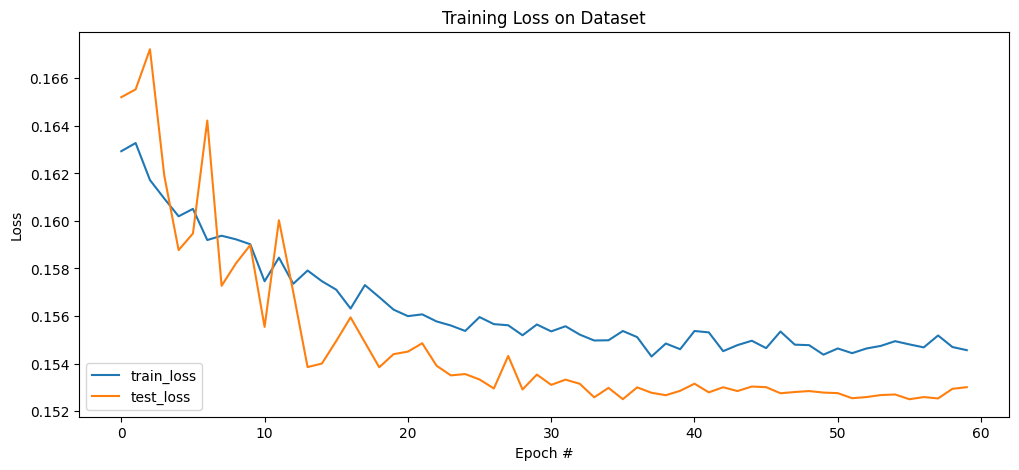

In [45]:
# plt.style.use("ggplot")
plt.figure(figsize=(12, 5))
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

In [46]:
from plots import make_predictions

In [47]:
test_images[0]


'/home/dah/computer_vision/datasets/segmentation_full_body_tik_tok_2615_img/images/95_00180.png'

In [48]:
test_masks[0]

'/home/dah/computer_vision/datasets/segmentation_full_body_tik_tok_2615_img/masks/95_00180.png'

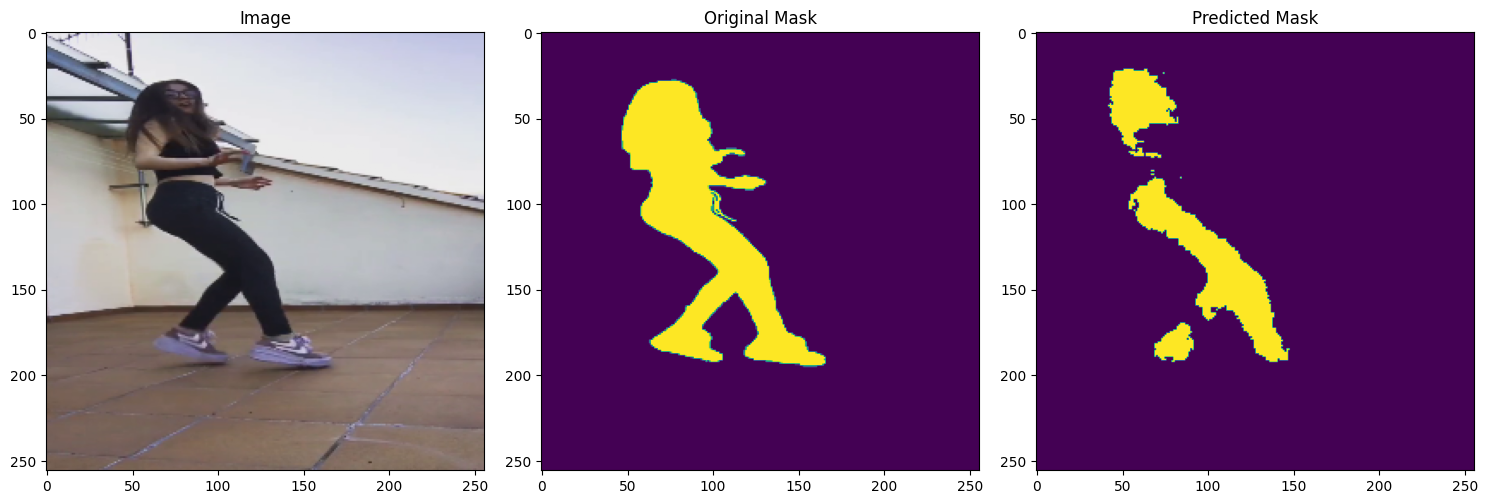

In [54]:
make_predictions(model=model, image_path = test_images[1], mask_path=test_masks[1], input_image_height=256, input_image_width=256, device = "cuda",threshold = THRESHOLD)
